In [1]:
!nvidia-smi

Tue Oct 26 05:40:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
dir = '/content/drive/My Drive/'
train_data = dir + 'train_buildings_data/'
train_label = dir + 'train_buildings_labeling/'

# 데이터 가져오기 확인

In [3]:
import numpy as np

In [18]:
file_list = [ _ for _ in os.listdir(train_label) if _.endswith(".png") ]
img = io.imread(os.path.join(train_label, file_list[1011]))

loc = (img[0][0][0], img[0][0][1], img[0][0][2])

unique_list = []
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        loc = (img[i][j][0], img[i][j][1], img[i][j][2])
        if loc not in unique_list:
            unique_list.append(loc)

unique_list

[(0, 0, 0),
 (255, 255, 255),
 (0, 0, 255),
 (255, 0, 0),
 (0, 255, 0),
 (0, 255, 255),
 (255, 255, 0)]

- 배경(0): (0,0,0) 검정
- 소형건물(1): (0, 0, 225) 파랑
- 공장(3): (225, 0, 0) 빨강
- 아파트(2): (0, 255, 0) 라임
- 대형건물(5): (0, 225, 225) 아쿠아
- 중형건물(4): (225, 225, 0) 노랑

(1024, 1024, 3)


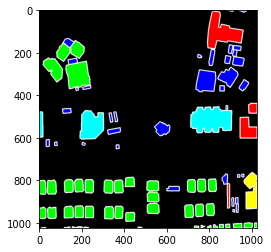

In [24]:
def show_image(dir):
    file_list = [ _ for _ in os.listdir(dir) if _.endswith(".png") ]

    # for i in range(1000, len(file_list)):
    plt.figure()
    img = io.imread(os.path.join(dir, file_list[1011]))
    print(img.shape)
    plt.imshow(img)
        # if i == 5:
        #     break

show_image(train_label)
# shape: (1024, 1024, 3)
# 총 1238 개 

In [4]:
import os
import matplotlib.pyplot as plt
from skimage import io

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)


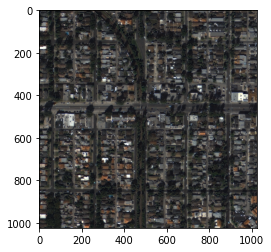

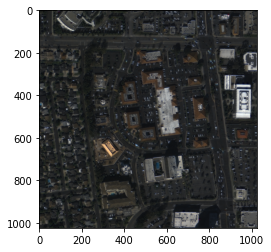

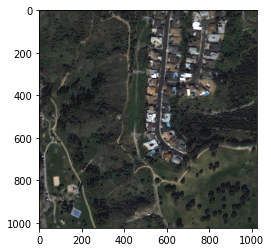

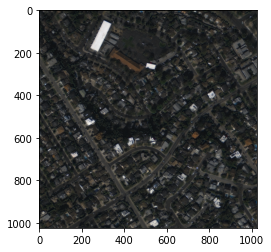

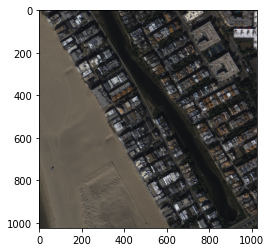

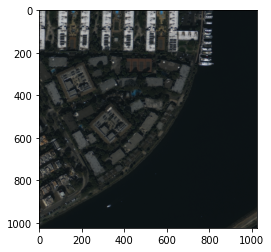

In [25]:
def show_image(dir):
    file_list = [ _ for _ in os.listdir(dir) if _.endswith(".png") ]

    for i in range(len(file_list)):
        plt.figure()
        img = io.imread(os.path.join(dir, file_list[i]))
        print(img.shape)
        plt.imshow(img)
        if i == 5:
            break

show_image(train_data)
# shape: (1024, 1024, 3)
# 총 1238 개 

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)


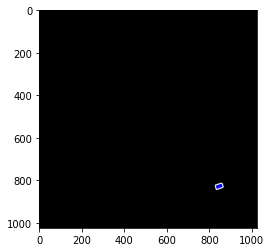

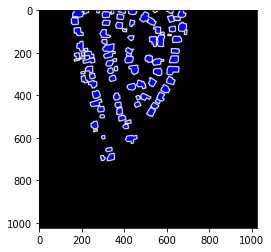

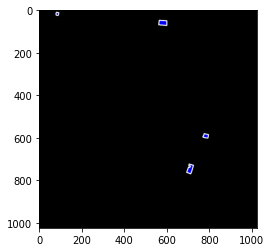

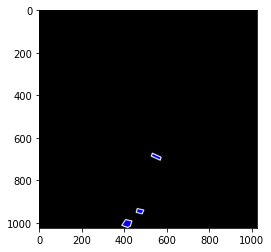

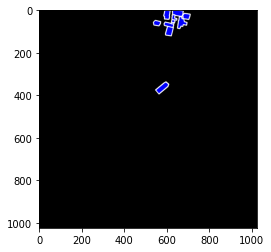

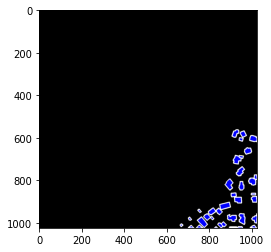

In [6]:
show_image(train_label)

# 데이터로더 만들기

dataloader.py용

In [5]:
import os
import cv2

import albumentations as A
from albumentations.pytorch import ToTensor

from torch.utils.data import Dataset, DataLoader
from torchvision import utils

In [6]:
__all__ = ["BuildingDataset", "fetch_dataloader"]

class BuildingDataset(Dataset):
    def __init__(self, image_paths, label_paths, transform=None):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform

    def __len__(self): 
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label_path = self.label_paths[idx]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        
        return image, mask #{'image': image, 'mask': mask } 

def fetch_dataloader(types, data_dir, batch_size, num_workers):
    dataloaders = {}

    image_dir = os.path.join(data_dir, "train_buildings_data")
    label_dir = os.path.join(data_dir, "train_buildings_labeling")

    train_files = [ _ for _ in os.listdir(image_dir) if _.endswith(".png") ]
    train_label_files = [ _ for _ in os.listdir(label_dir) if _.endswith(".png") ]

    train_image_paths = [os.path.join(image_dir, file_name) for file_name in train_files]
    train_label_paths = [os.path.join(label_dir, file_name) for file_name in train_label_files]

    transform = A.Compose([
        # A.LongestMaxSize(max_size=448),
        # A.PadIfNeeded(min_height=448, min_width=448, border_mode=cv2.BORDER_CONSTANT),
        A.Normalize(),
        ToTensor()
    ])

    dl = DataLoader(BuildingDataset(train_image_paths, train_label_paths, transform=transform),
                    batch_size,
                    shuffle=True,
                    num_workers=num_workers            
        )
    
    dataloaders[types] = dl

    return dataloaders

In [28]:
dataloaders = fetch_dataloader("train",
                                data_dir=dir,
                                batch_size=4,
                                num_workers = 2
                            )
train_loader = dataloaders['train']

0 torch.Size([4, 3, 1024, 1024]) torch.Size([4, 1, 1024, 1024])
1 torch.Size([4, 3, 1024, 1024]) torch.Size([4, 1, 1024, 1024])
2 torch.Size([4, 3, 1024, 1024]) torch.Size([4, 1, 1024, 1024])
3 torch.Size([4, 3, 1024, 1024]) torch.Size([4, 1, 1024, 1024])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


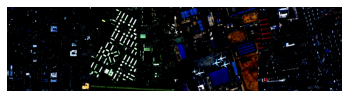

In [29]:
for i_batch, sample_batch in enumerate(train_loader):
    image, mask = sample_batch
    print(i_batch, image.size(), mask.size())
   
    if i_batch == 3:
        plt.figure()
        grid = utils.make_grid(image)
        plt.imshow(grid.numpy().transpose(1,2,0))
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

# 모델 아키텍처 불러오기

In [7]:
import torch
import torch.nn as nn

In [31]:
class FCN32s(nn.Module):
    def __init__(self, num_classes=1024):
        super(FCN32s, self).__init__()
        self.relu = nn.ReLU(inplace=True)

        # conv1 
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=100)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        # conv2 
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        # conv3
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        # conv4
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        # conv3
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        # fc1
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc2
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        # fc3
        self.score_fr = nn.Conv2d(4096, num_classes, kernel_size = 1)
        self.upscore32 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size = 64, stride = 32)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.xavier_uniform_(m.weight)

                # xavier_uniform은 bias에 대해서는 제공하지 않음 
                # ValueError: Fan in and fan out can not be computed for tensor with fewer than 2 dimensions
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)


    def forward(self, x):
        o_h, o_w = x.size()[2], x.size()[3]
        h = self.relu1_1(self.conv1_1(x))
        h = self.relu1_2(self.conv1_2(h))
        h = self.pool1(h)

        h = self.relu2_1(self.conv2_1(h))
        h = self.relu2_2(self.conv2_2(h))
        h = self.pool2(h)

        h = self.relu3_1(self.conv3_1(h))
        h = self.relu3_2(self.conv3_2(h))
        h = self.relu3_3(self.conv3_3(h))
        h = self.pool3(h)

        h = self.relu4_1(self.conv4_1(h))
        h = self.relu4_2(self.conv4_2(h))
        h = self.relu4_3(self.conv4_3(h))
        h = self.pool4(h)

        h = self.relu5_1(self.conv5_1(h))
        h = self.relu5_2(self.conv5_2(h))
        h = self.relu5_3(self.conv5_3(h))
        h = self.pool5(h)

        h = self.relu6(self.fc6(h))
        h = self.drop6(h)

        h = self.relu7(self.fc7(h))
        h = self.drop7(h)

        h = self.score_fr(h)
        upscore32 = self.upscore32(h)  

        u_h, u_w = upscore32.size()[2], upscore32.size()[3]
        dh, dw = (u_h - o_h)//2, (u_w - o_w)//2
        return torch.sigmoid(upscore32[:, :, dh:(dh + o_h), dw:(dw + o_w)])


In [13]:
class FCN16s(nn.Module):
    def __init__(self, num_classes=1024):
        super(FCN16s, self).__init__()
        self.relu = nn.ReLU(inplace=True)

        # conv1 
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=100)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        # conv2 
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        # conv3
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        # conv4
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        # conv5
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        self.score_pool4 = nn.Conv2d(512, num_classes, 1)

        # fc1
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc2
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        # fc3
        self.score_fr = nn.Conv2d(4096, num_classes, kernel_size = 1)
        self.upscore2 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size = 4, stride = 2)
        self.upscore16 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size = 32, stride = 16)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.xavier_uniform_(m.weight)

                # xavier_uniform은 bias에 대해서는 제공하지 않음 
                # ValueError: Fan in and fan out can not be computed for tensor with fewer than 2 dimensions
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)


    def forward(self, x):
        h = self.relu1_1(self.conv1_1(x))
        h = self.relu1_2(self.conv1_2(h))
        h = self.pool1(h)

        h = self.relu2_1(self.conv2_1(h))
        h = self.relu2_2(self.conv2_2(h))
        h = self.pool2(h)

        h = self.relu3_1(self.conv3_1(h))
        h = self.relu3_2(self.conv3_2(h))
        h = self.relu3_3(self.conv3_3(h))
        h = self.pool3(h)

        h = self.relu4_1(self.conv4_1(h))
        h = self.relu4_2(self.conv4_2(h))
        h = self.relu4_3(self.conv4_3(h))
        pool4 = h = self.pool4(h)

        h = self.relu5_1(self.conv5_1(h))
        h = self.relu5_2(self.conv5_2(h))
        h = self.relu5_3(self.conv5_3(h))
        h = self.pool5(h)

        h = self.relu6(self.fc6(h))
        h = self.drop6(h)

        h = self.relu7(self.fc7(h))
        h = self.drop7(h)

        h = self.score_fr(h)
        upscore2 = self.upscore2(h)         
        pool4 = self.score_pool4(pool4)

        dh, dw = (pool4.size()[2] - upscore2.size()[2])//2, (pool4.size()[3] - upscore2.size()[3])//2
        upscore16 = self.upscore16(upscore2 + pool4[:, :, dh:(dh + upscore2.size()[2]), dw:(dw + upscore2.size()[3])]) 

        dh, dw = (upscore16.size()[2] - x.size()[2])//2, (upscore16.size()[3] - x.size()[3])//2
        return torch.sigmoid(upscore16[:, :, dh:(dh + x.size()[2]), dw:(dw + x.size()[3])])

In [14]:
class FCN8s(nn.Module):
    def __init__(self, num_classes=1024):
        super(FCN8s, self).__init__()
        self.relu    = nn.ReLU(inplace=True)

        # conv1 
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=100)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        # conv2 
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        # conv3
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        # conv4
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        # conv3
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True) 

        self.score_pool3 = nn.Conv2d(256, num_classes, 1)
        self.score_pool4 = nn.Conv2d(512, num_classes, 1)

        # fc1
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc2
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        # fc3
        self.score_fr = nn.Conv2d(4096, num_classes, kernel_size = 1)
        self.upscore2 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size = 4, stride = 2)
        self.upscore2_pool4 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size = 4, stride = 2)
        self.upscore8 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size = 16, stride = 8)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.xavier_uniform_(m.weight)

                # xavier_uniform은 bias에 대해서는 제공하지 않음 
                # ValueError: Fan in and fan out can not be computed for tensor with fewer than 2 dimensions
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)


    def forward(self, x):
        h = self.relu1_1(self.conv1_1(x))
        h = self.relu1_2(self.conv1_2(h))
        h = self.pool1(h)

        h = self.relu2_1(self.conv2_1(h))
        h = self.relu2_2(self.conv2_2(h))
        h = self.pool2(h)

        h = self.relu3_1(self.conv3_1(h))
        h = self.relu3_2(self.conv3_2(h))
        h = self.relu3_3(self.conv3_3(h))
        pool3 = h = self.pool3(h)

        h = self.relu4_1(self.conv4_1(h))
        h = self.relu4_2(self.conv4_2(h))
        h = self.relu4_3(self.conv4_3(h))
        pool4 = h = self.pool4(h)

        h = self.relu5_1(self.conv5_1(h))
        h = self.relu5_2(self.conv5_2(h))
        h = self.relu5_3(self.conv5_3(h))
        h = self.pool5(h)

        h = self.relu6(self.fc6(h))
        h = self.drop6(h)

        h = self.relu7(self.fc7(h))
        h = self.drop7(h)

        pool3 = self.score_pool3(pool3)
        pool4 = self.score_pool4(pool4)

        h = self.score_fr(h)
        upscore2 = self.upscore2(h)         

        dh, dw = (pool4.size()[2] - upscore2.size()[2])//2, (pool4.size()[3] - upscore2.size()[3])//2
        upscore2_pool4 = self.upscore2_pool4(upscore2 + pool4[:, :, dh:(dh + upscore2.size()[2]), dw:(dw + upscore2.size()[3])])

        dh, dw = (pool3.size()[2] - upscore2_pool4.size()[2])//2, (pool3.size()[3] - upscore2_pool4.size()[3])//2
        upscore8 = self.upscore8(upscore2_pool4 + pool3[:, :, dh:(dh + upscore2_pool4.size()[2]), dw:(dw + upscore2_pool4.size()[3])])

        dh, dw = (upscore8.size()[2] - x.size()[2])//2, (upscore8.size()[3] - x.size()[3])//2
        return torch.sigmoid(upscore8[:, :, dh:(dh + x.size()[2]), dw:(dw + x.size()[3])])

In [ ]:
# RAM 부족으로 테스트가 안됨...
net = FCN32s()
x = torch.randn(2, 3, 1024, 1024)
y = net(x)
print(y.size())
print(y)

# Metric.py용

In [8]:
import cv2
import numpy as np
from tqdm import tqdm

import torch
import torch.nn.functional as F
from albumentations.augmentations.functional import center_crop

In [39]:
__all__ = ['Evaluator', 'train', 'validation']

class Evaluator():
    def __init__(self, num_classes):
        self.num_classes = num_classes

    def reset(self):
        self.count = np.zeros(self.num_classes, dtype=np.int32)
        self.iou = np.zeros(self.num_classes, dtype=np.float32)
        self.acc = np.zeros(self.num_classes, dtype=np.float32)

    def predict_masks(self, outputs):
        pred_masks = torch.argmax(F.softmax(outputs, dim=1), dim=1)
        return pred_masks

    def evaluate(self, data_loader, model, device):
        running_miou = []
        running_macc = []
        tbar = tqdm(data_loader, desc="evaluation steps", total=len(data_loader))

        model.eval()
        with torch.no_grad():
            for images, gt_masks in tbar:
                images, gt_masks = images.to(device), gt_masks.to(device).long()

                score_masks = model(images)
                pred_masks = self.predict_masks(score_masks)

                for pd_msk, gt_msk in zip(pred_masks.cpu().numpy().astype(np.uint8),
                                        gt_masks.cpu().numpy().astype(np.uint8)):

                    class_list = np.unique(gt_msk)
                    for class_idx in class_list:
                        intersection = ((class_idx == gt_msk) & (class_idx == pd_msk)).astype(np.float32).sum()
                        union = ((class_idx == gt_msk) | (class_idx == pd_msk)).astype(np.float32).sum()
                        gt_pixel = (class_idx == gt_msk).astype(np.float32).sum()

                        self.iou[class_idx] += intersection / union
                        self.acc[class_idx] += intersection / gt_pixel
                        self.count[class_idx] += 1

    def get_metrics(self):
        iou = self.iou / self.count
        pixel_acc = self.acc / self.count

        mean_iou = np.mean(iou)
        mean_acc = np.mean(pixel_acc)

        return iou, pixel_acc, mean_iou, mean_acc

In [40]:
def train(data_loader, model, loss_fn, optimizer, device):
    running_loss = []
    tbar = tqdm(data_loader, desc="train steps", total=len(data_loader))
    
    model.train()
    for images, gt_masks in tbar:
        images, gt_masks = images.to(device), gt_masks.to(device).long()

        optimizer.zero_grad()
        score_masks = model(images)
        loss = loss_fn(score_masks, gt_masks)
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.item())
            
    return np.mean(running_loss)


def validation(data_loader, model, loss_fn, device):
    running_loss = []
    tbar = tqdm(data_loader, desc="valid steps", total=len(data_loader))
    
    model.eval()
    with torch.no_grad():
        for images, gt_masks in tbar:
            images, gt_masks = images.to(device), gt_masks.to(device).long()

            score_masks = model(images)
            loss = loss_fn(score_masks, gt_masks)

            running_loss.append(loss.item())
            
    return np.mean(running_loss)

# main.py용

In [41]:
import os
import argparse
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import SGD, lr_scheduler
from torch.utils.tensorboard import SummaryWriter

# from models import unet
# from models import Evaluator, train, validation
# from datasets import fetch_dataloader

In [45]:
parser = argparse.ArgumentParser()

def str2bool(arg):
    if isinstance(arg, bool):
        return arg
    elif arg.lower() in ("t", "true", "y", "yes", "1"):
        return True
    elif arg.lower() in ("f", "false", "n", "no", "0"):
        return False
    else:
        return None

parser.add_argument("--data_dir", default=dir, type=str,
                    help="Directory containing the dataset")

parser.add_argument("--save_dir", default="experiments", type=str,
                    help="Directory containing model checkpoints")

parser.add_argument("--tensorboard_dir", default="runs", type=str,
                    help="Directory containing tensorboard events")

parser.add_argument("--num_classes", default=1024, type=int,
                    help="Number of classes")

parser.add_argument("--epochs", default=100, type=int,
                    help="Number of epochs")

parser.add_argument("--batch_size", default=4, type=int,
                    help="Number of mini-batch size")

parser.add_argument("--learning_rate", default=0.1, type=float,
                    help="Initial learning rate")

_StoreAction(option_strings=['--learning_rate'], dest='learning_rate', nargs=None, const=None, default=0.1, type=<class 'float'>, choices=None, help='Initial learning rate', metavar=None)

In [56]:
args = parser.parse_args("")
# data directory path check
assert os.path.exists(args.data_dir), "Data directory does not exist!"
# save directory path check
if not os.path.exists(args.save_dir):
    os.mkdir("experiments")

torch.manual_seed(11)
if torch.cuda.is_available():
    torch.cuda.manual_seed(11)
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

dataloaders = fetch_dataloader("train",
                                data_dir=args.data_dir,
                                batch_size=args.batch_size,
                                num_workers=2)

train_loader = dataloaders["train"]

model = FCN32s(args.num_classes)
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=args.learning_rate)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                            factor=0.1,
                                            patience=5)

writer = SummaryWriter(os.path.join(args.tensorboard_dir, "fcn32"))
evaluator = Evaluator(args.num_classes)
best_mean_iou = 0

for epoch in range(args.epochs):
    # train
    train_loss = train(train_loader, model, loss_fn, optimizer, device)

    # validation
    val_loss = validation(val_loader, model, loss_fn, device)

    # evaluate miou, pixel accuracy
    evaluator.reset()
    evaluator.evaluate(eval_loader, model, device)
    iou, pixel_acc, mean_iou, mean_acc = evaluator.get_metrics()

    print((f"Epoch {epoch + 1}/{args.epochs}\n"
            f"[Train] loss: {train_loss:.3f}\n"
            f"[Valid] loss: {val_loss:.3f}, mIoU: {mean_iou:.3f}, Mean Accuracy: {mean_acc:.3f}"))

    writer.add_scalars("Loss", {"train": train_loss, "valid": val_loss}, epoch + 1)
    writer.add_scalar("Mean IoU", mean_iou, epoch + 1)
    writer.add_scalar("Mean Accuracy", mean_acc, epoch + 1)
    writer.add_scalars("IoU", 
        {"0. background": iou[0],
        "1. aeroplane":  iou[1],
        "2. bicycle":    iou[2],
        "3. bird":       iou[3],
        "4. boat":       iou[4],
        "5. bottle":     iou[5],
        }, epoch + 1)
    writer.add_scalars("Pixel_Accuracy", 
        {"0. background": pixel_acc[0],
        "1. aeroplane":   pixel_acc[1],
        "2. bicycle":     pixel_acc[2],
        "3. bird":        pixel_acc[3],
        "4. boat":        pixel_acc[4],
        "5. bottle":      pixel_acc[5],
        }, epoch + 1)

    if (mean_iou > best_mean_iou):
        torch.save({"epoch": epoch + 1,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "scheduler": scheduler.state_dict()},
                    os.path.join(args.save_dir, f"unet_best_miou_{mean_iou:.3f}.tar"))
        best_mean_iou = mean_iou
        print(f"Saved best model - best_miou: {best_mean_iou:.3f}")

    scheduler.step(val_loss)
    
writer.close()

cuda
